# Analisis espacial

## Autor: Pedro Jose Leal

### Descripción de la Base de Datos: US-Accidents

Este es un conjunto de datos de accidentes automovilísticos a nivel nacional que abarca 49 estados de los EE. UU.. Los datos de los accidentes se recopilaron desde febrero de 2016 hasta marzo de 2023, utilizando múltiples API que proporcionan datos de incidentes de tráfico en tiempo real.

Estas API transmiten datos de tráfico capturados por diversas entidades, como los departamentos de transporte estatales y de EE. UU., agencias de aplicación de la ley, cámaras de tráfico y sensores de tráfico dentro de las redes de carreteras. Actualmente, hay aproximadamente 7.7 millones de registros de accidentes en este conjunto de datos.

Para el análisis de datos que se va a comenzar, solo se utilizarán las siguientes variables del conjunto de datos:

*   `ID`: Identificador único para cada registro de accidente.
*   `Start_Time`: Muestra la hora de inicio del accidente en la zona horaria local.
*   `Start_Lat`: Muestra la latitud en coordenadas GPS del punto de inicio del accidente.
*   `Start_Lng`: Muestra la longitud en coordenadas GPS del punto de inicio del accidente.
*   `Temperature(F)`: Indica la temperatura en grados Fahrenheit en el lugar del accidente.
*   `Humidity(%)`: Muestra la humedad en porcentaje.
*   `Pressure(in)`: Indica la presión atmosférica en pulgadas de mercurio.

## 1. Analisis de los datos

Cargando y filtrando el dataset...
Dataset cargado con 6985228 registros iniciales.

--- Limpieza Avanzada de Datos ---
Se eliminaron 164846 registros con valores nulos o cero.
El dataset final tiene 6820382 registros válidos.

--- Análisis de Estaciones ---
Hay 2753388 estaciones únicas en el dataset.

--- Análisis de Reportes por Hora ---
Generando diagrama de barras de reportes por hora...


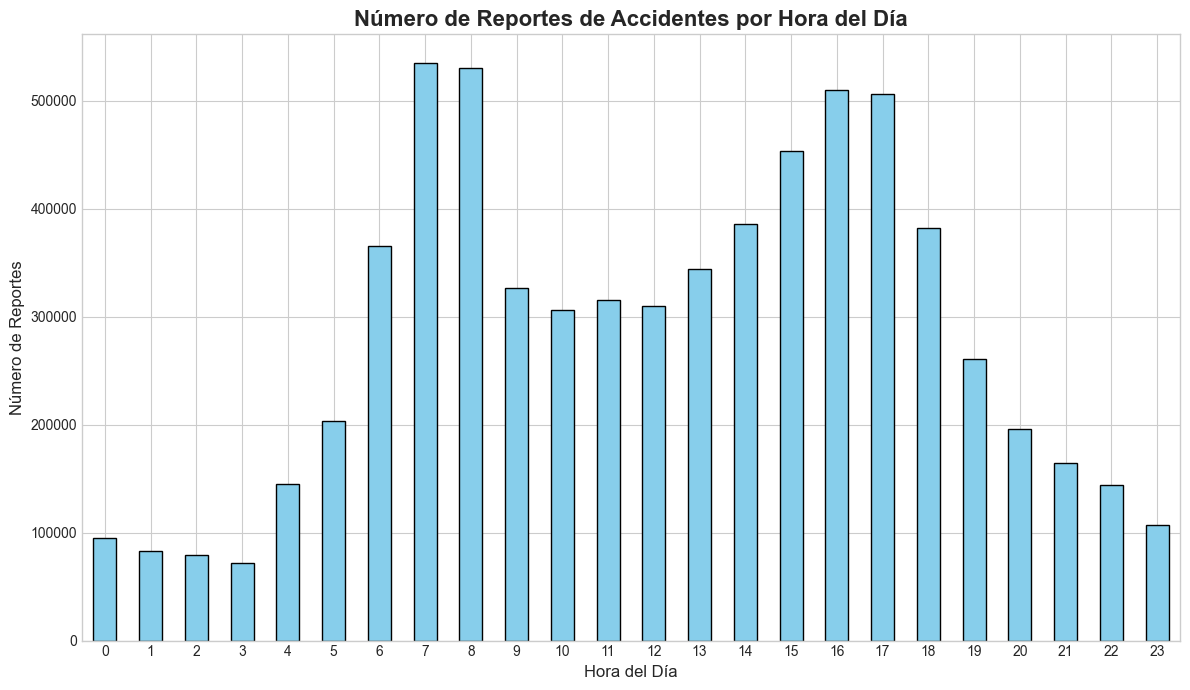


--- Generando Mapas de Calor con Coordenadas Planas ---
Creando GeoDataFrame a partir de Latitud y Longitud (EPSG:4326)...
Proyectando a coordenadas planas (Albers Equal Area - ESRI:102003)...


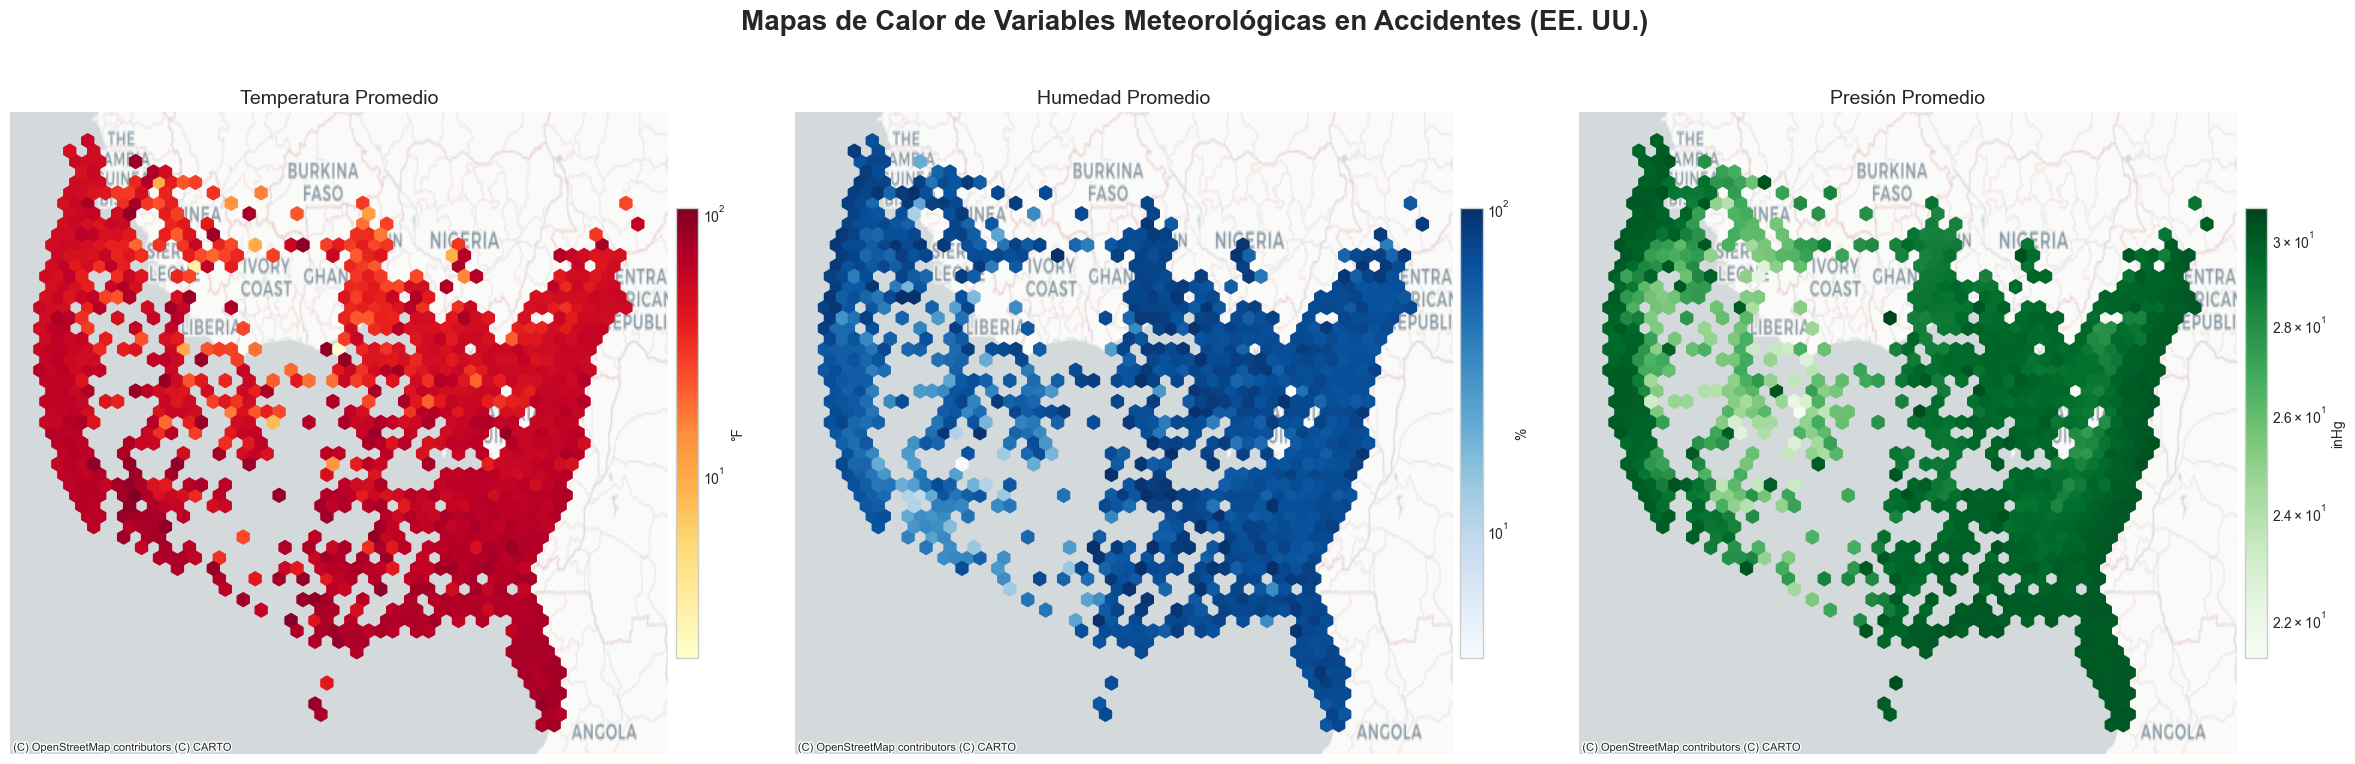

In [2]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# --- PASO 2: DEFINICIÓN DE FUNCIONES ---

# Las funciones cargar_y_preparar_datos, limpiar_datos_invalidos,
# analizar_estaciones y graficar_reportes_por_hora no necesitan cambios
# y se mantienen como en la versión anterior.

def cargar_y_preparar_datos(path, columnas):
    """
    Carga el dataset desde un archivo CSV, filtra por columnas y realiza una limpieza inicial.
    """
    print("Cargando y filtrando el dataset...")
    df = pd.read_csv(path, usecols=columnas)
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df.dropna(subset=['Start_Time', 'Start_Lat', 'Start_Lng'], inplace=True)
    print(f"Dataset cargado con {len(df)} registros iniciales.")
    return df

def limpiar_datos_invalidos(df, columnas_a_validar):
    """
    Elimina registros que contienen valores nulos o cero en columnas específicas.
    """
    print("\n--- Limpieza Avanzada de Datos ---")
    registros_antes = len(df)
    df.dropna(subset=columnas_a_validar, inplace=True)
    for col in columnas_a_validar:
        df = df[df[col].ne(0)]
    registros_despues = len(df)
    print(f"Se eliminaron {registros_antes - registros_despues} registros con valores nulos o cero.")
    print(f"El dataset final tiene {registros_despues} registros válidos.")
    return df

def analizar_estaciones(df):
    """
    Crea una columna 'estacion' y cuenta el número de estaciones únicas.
    """
    print("\n--- Análisis de Estaciones ---")
    df['estacion'] = df['Start_Lat'].astype(str) + ',' + df['Start_Lng'].astype(str)
    numero_de_estaciones = df['estacion'].nunique()
    print(f"Hay {numero_de_estaciones} estaciones únicas en el dataset.")
    return df

def graficar_reportes_por_hora(df):
    """
    Genera y muestra un diagrama de barras del número de reportes por hora.
    """
    print("\n--- Análisis de Reportes por Hora ---")
    df['Hour'] = df['Start_Time'].dt.hour
    reportes_por_hora = df['Hour'].value_counts().sort_index()
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    reportes_por_hora.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title('Número de Reportes de Accidentes por Hora del Día', fontsize=16, fontweight='bold')
    ax.set_xlabel('Hora del Día', fontsize=12)
    ax.set_ylabel('Número de Reportes', fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    print("Generando diagrama de barras de reportes por hora...")
    plt.tight_layout()
    plt.show()

# --- FUNCIÓN MODIFICADA ---
def graficar_mapas_de_calor(df, sample_size=50000):
    """
    Proyecta las coordenadas a un sistema plano (Albers para EE. UU.) y genera mapas de calor.
    
    Args:
        df (pandas.DataFrame): DataFrame con datos geoespaciales y meteorológicos.
        sample_size (int): Número de muestras a usar para la visualización.
    """
    print("\n--- Generando Mapas de Calor con Coordenadas Planas ---")
    if len(df) < sample_size:
        sample_size = len(df)
    
    df_sample = df.sample(n=sample_size, random_state=42)
    
    print("Creando GeoDataFrame a partir de Latitud y Longitud (EPSG:4326)...")
    geometry = [Point(xy) for xy in zip(df_sample['Start_Lng'], df_sample['Start_Lat'])]
    gdf = gpd.GeoDataFrame(df_sample, geometry=geometry, crs="EPSG:4326")

    # --- CAMBIO CLAVE: Proyección a Coordenadas Planas ---
    # Se convierte de coordenadas geográficas (lat/lon) a la proyección Albers para EE.UU.
    # El resultado son coordenadas X,Y en metros, que son las coordenadas planas "Este" y "Norte".
    print("Proyectando a coordenadas planas (Albers Equal Area - ESRI:102003)...")
    gdf = gdf.to_crs("ESRI:102003")
    
    # --- NUEVO: Extraer coordenadas planas a columnas 'Este' y 'Norte' ---
    gdf['Este'] = gdf.geometry.x
    gdf['Norte'] = gdf.geometry.y

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
    plt.suptitle('Mapas de Calor de Variables Meteorológicas en Accidentes (EE. UU.)', fontsize=20, fontweight='bold')

    variables = {
        'Temperatura': ('Temperature(F)', 'YlOrRd', '°F'),
        'Humedad': ('Humidity(%)', 'Blues', '%'),
        'Presión': ('Pressure(in)', 'Greens', 'inHg')
    }
    
    for i, (nombre, (col, cmap, label)) in enumerate(variables.items()):
        ax = axes[i]
        # Ahora usamos las nuevas coordenadas planas 'Este' y 'Norte' para el gráfico
        hb = ax.hexbin(gdf['Este'], gdf['Norte'], C=gdf[col], reduce_C_function=np.mean, gridsize=50, cmap=cmap, bins='log')
        ax.set_title(f'{nombre} Promedio', fontsize=14)
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
        cb = fig.colorbar(hb, ax=ax, orientation='vertical', pad=0.01, shrink=0.7)
        cb.set_label(label)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- PASO 3: EJECUCIÓN PRINCIPAL DEL SCRIPT ---

# --- CONFIGURACIÓN ---
path_al_archivo_csv = "./Datos/US_Accidents_March23.csv"
columnas_fundamentales = ['ID', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)']
columnas_a_validar = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)']

# --- FLUJO DE TRABAJO ---
# 1. Cargar datos
df = cargar_y_preparar_datos(path_al_archivo_csv, columnas_fundamentales)
    
# 2. Limpiar valores nulos y ceros
df_limpio = limpiar_datos_invalidos(df, columnas_a_validar)
    
# 3. Analizar y contar estaciones
df_con_estaciones = analizar_estaciones(df_limpio)
    
# 4. Graficar reportes por hora
graficar_reportes_por_hora(df_con_estaciones)
    
# 5. Graficar mapas de calor (usando la nueva función con proyección)
graficar_mapas_de_calor(df_con_estaciones)

## 2. Paso a coordenadas cuadradas y selección de la hora

Se ha creado un DataFrame 'df_7am' con 534767 registros para las 7:00.
Convirtiendo coordenadas geográficas a coordenadas planas (Este/Norte)...
Proyección completada.
Se ha tomado una muestra de 5000 registros para las visualizaciones.
Generando los gráficos de dispersión 3D...


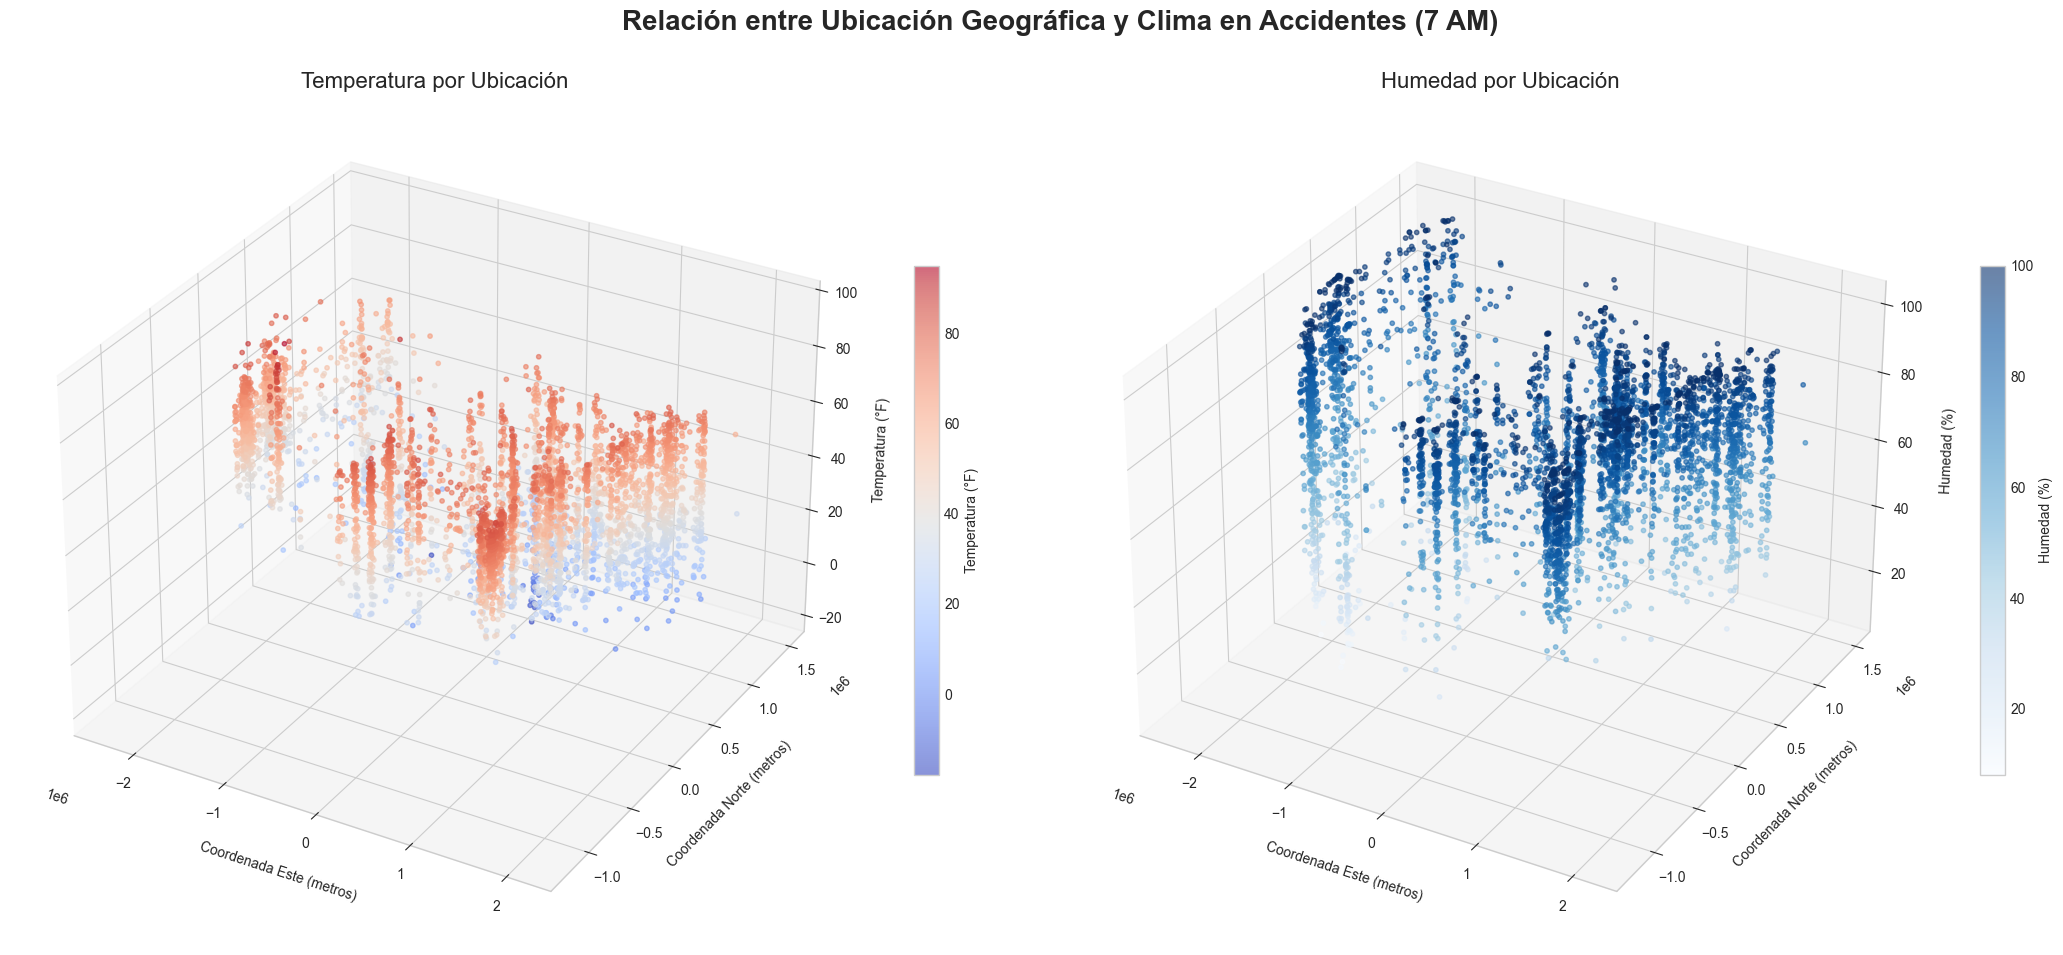


--- ANÁLISIS BIVARIADO CON MATRIZ DE DISPERSIÓN ---
Generando la matriz de diagramas de dispersión (pairplot)...


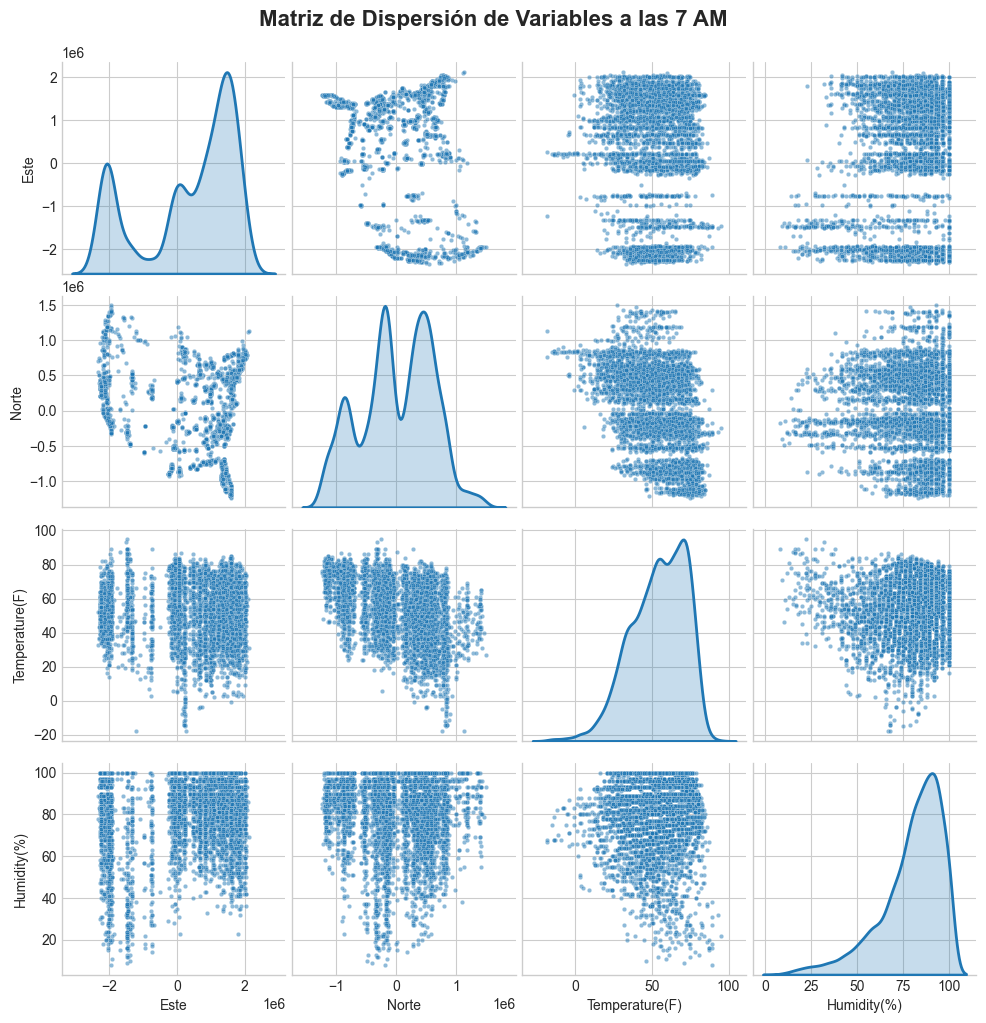

In [8]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Esencial para registrar la proyección 3D
import seaborn as sns                   # Importamos Seaborn para el pairplot

# --- PASO 2: FILTRADO Y PROYECCIÓN DE DATOS (7 AM) ---
# Se asume que 'df_con_estaciones' ya existe desde la ejecución de celdas anteriores.

hora_de_interes = 7
df_7am = df_con_estaciones[df_con_estaciones['Start_Time'].dt.hour == hora_de_interes].copy()

print(f"Se ha creado un DataFrame 'df_7am' con {len(df_7am)} registros para las {hora_de_interes}:00.")

# --- Proyección a Coordenadas Planas ---
print("Convirtiendo coordenadas geográficas a coordenadas planas (Este/Norte)...")
geometry = [Point(xy) for xy in zip(df_7am['Start_Lng'], df_7am['Start_Lat'])]
gdf_7am = gpd.GeoDataFrame(df_7am, geometry=geometry, crs="EPSG:4326")

# Proyectamos a Albers Equal Area para EE.UU.
gdf_7am_proyectado = gdf_7am.to_crs("ESRI:102003")

# Extraemos las coordenadas planas (en metros) a nuevas columnas.
gdf_7am_proyectado['Este'] = gdf_7am_proyectado.geometry.x
gdf_7am_proyectado['Norte'] = gdf_7am_proyectado.geometry.y
print("Proyección completada.")

# --- PASO 3: TOMA DE MUESTRA PARA VISUALIZACIÓN ---

columnas_para_grafico = ['Este', 'Norte', 'Temperature(F)', 'Humidity(%)']
df_final = gdf_7am_proyectado[columnas_para_grafico].dropna()

sample_size = 5000
if len(df_final) < sample_size:
    sample_size = len(df_final)

df_sample = df_final.sample(n=sample_size, random_state=42)
print(f"Se ha tomado una muestra de {len(df_sample)} registros para las visualizaciones.")


# --- PASO 4: CREACIÓN DE LOS GRÁFICOS DE DISPERSIÓN 3D ---

print("Generando los gráficos de dispersión 3D...")

fig = plt.figure(figsize=(22, 10))
plt.suptitle('Relación entre Ubicación Geográfica y Clima en Accidentes (7 AM)', fontsize=20, fontweight='bold')

# --- Gráfico 1: Temperatura ---
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    df_sample['Este'], df_sample['Norte'], df_sample['Temperature(F)'],
    c=df_sample['Temperature(F)'], cmap='coolwarm', s=10, alpha=0.6
)
ax1.set_title('Temperatura por Ubicación', fontsize=16)
ax1.set_xlabel('Coordenada Este (metros)', fontsize=10, labelpad=10)
ax1.set_ylabel('Coordenada Norte (metros)', fontsize=10, labelpad=10)
ax1.set_zlabel('Temperatura (°F)', fontsize=10, labelpad=10)
fig.colorbar(sc1, ax=ax1, shrink=0.6, label='Temperatura (°F)')

# --- Gráfico 2: Humedad ---
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    df_sample['Este'], df_sample['Norte'], df_sample['Humidity(%)'],
    c=df_sample['Humidity(%)'], cmap='Blues', s=10, alpha=0.6
)
ax2.set_title('Humedad por Ubicación', fontsize=16)
ax2.set_xlabel('Coordenada Este (metros)', fontsize=10, labelpad=10)
ax2.set_ylabel('Coordenada Norte (metros)', fontsize=10, labelpad=10)
ax2.set_zlabel('Humedad (%)', fontsize=10, labelpad=10)
fig.colorbar(sc2, ax=ax2, shrink=0.6, label='Humedad (%)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- PASO 5: (NUEVO) CREACIÓN DE LA MATRIZ DE DISPERSIÓN (PAIRPLOT) ---

print("\n" + "="*50)
print("--- ANÁLISIS BIVARIADO CON MATRIZ DE DISPERSIÓN ---")
print("="*50)
print("Generando la matriz de diagramas de dispersión (pairplot)...")

# Configuramos el estilo de Seaborn.
sns.set_style("whitegrid")

# Creamos el pairplot usando el mismo DataFrame de muestra (df_sample).
# En la diagonal se mostrarán estimaciones de densidad de kernel ('kde').
# En el resto de la matriz, se mostrarán diagramas de dispersión ('scatter').
pair_plot = sns.pairplot(
    df_sample,
    vars=['Este', 'Norte', 'Temperature(F)', 'Humidity(%)'],
    kind='scatter',
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 10}, # Argumentos para los gráficos de dispersión
    diag_kws={'linewidth': 2}        # Argumentos para los gráficos de densidad
)

# Añadimos un título general a la figura.
pair_plot.fig.suptitle('Matriz de Dispersión de Variables a las 7 AM', y=1.02, fontsize=16, fontweight='bold')

# Mostramos el gráfico.
plt.show()

## 3. Analisis de modelos de tendencia

In [5]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Para suprimir advertencias de Singular Matrix en PolyFeatures

# --- PASO 2: PREPARACIÓN DE DATOS PARA EL MODELADO (VERSIÓN CORREGIDA) ---
# Se utiliza el GeoDataFrame 'gdf_7am_proyectado' de la celda anterior, que contiene las coordenadas planas.

print("Preparando datos para el modelado usando coordenadas planas (Este, Norte)...")

# Seleccionar las columnas necesarias y eliminar filas con valores nulos para evitar errores.
columnas_modelo = ['Este', 'Norte', 'Temperature(F)', 'Humidity(%)']
df_model = gdf_7am_proyectado[columnas_modelo].dropna()

# Definir las variables predictoras (X) y las variables objetivo (y)
# X ahora son las coordenadas planas, que son más adecuadas para un modelo de regresión.
X = df_model[['Este', 'Norte']] 
y_temp = df_model['Temperature(F)']
y_hum = df_model['Humidity(%)']

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%) para la temperatura
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X, y_temp, test_size=0.2, random_state=42
)

# Dividir los datos para la humedad (usando el mismo 'random_state' para consistencia)
X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(
    X, y_hum, test_size=0.2, random_state=42
)

print(f"Datos listos. Usando {len(X_train_temp)} registros para entrenar y {len(X_test_temp)} para probar.")


# --- PASO 3: FUNCIÓN PARA AJUSTAR Y EVALUAR LOS MODELOS ---
# (Esta función no necesita cambios, ya que es genérica y funciona con los datos de entrada)
results = {}

def fit_and_evaluate(model_type, X_train, y_train, X_test, y_test, target_variable_name):
    """
    Ajusta un modelo, lo evalúa y muestra su R^2.
    """
    if model_type == 'simple':
        poly_features = PolynomialFeatures(degree=1, include_bias=False)
    elif model_type == 'interaccion':
        poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    elif model_type == 'polinomial':
        poly_features = PolynomialFeatures(degree=2, include_bias=False)
    
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Modelo: {model_type.capitalize():<12} | R^2 = {r2:.4f}")
    
    if target_variable_name not in results:
        results[target_variable_name] = []
    results[target_variable_name].append({'modelo': model_type.capitalize(), 'R2': r2})

# --- PASO 4: EJECUCIÓN PARA TEMPERATURA ---
print("\n--- AJUSTE DE MODELOS PARA LA TEMPERATURA ---")
fit_and_evaluate('simple', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')
fit_and_evaluate('interaccion', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')
fit_and_evaluate('polinomial', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')

# --- PASO 5: EJECUCIÓN PARA HUMEDAD ---
print("\n--- AJUSTE DE MODELOS PARA LA HUMEDAD ---")
fit_and_evaluate('simple', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')
fit_and_evaluate('interaccion', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')
fit_and_evaluate('polinomial', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')

# --- PASO 6: CONCLUSIÓN ---
print("\n--- CONCLUSIÓN ---")
for var, res in results.items():
    best_model = max(res, key=lambda x: x['R2'])
    print(f"Para la {var}, el mejor modelo es el '{best_model['modelo']}' con un R^2 de {best_model['R2']:.4f}.")

Preparando datos para el modelado usando coordenadas planas (Este, Norte)...
Datos listos. Usando 427813 registros para entrenar y 106954 para probar.

--- AJUSTE DE MODELOS PARA LA TEMPERATURA ---
Modelo: Simple       | R^2 = 0.2075
Modelo: Interaccion  | R^2 = 0.2087
Modelo: Polinomial   | R^2 = 0.2342

--- AJUSTE DE MODELOS PARA LA HUMEDAD ---
Modelo: Simple       | R^2 = 0.0647
Modelo: Interaccion  | R^2 = 0.1101
Modelo: Polinomial   | R^2 = 0.1109

--- CONCLUSIÓN ---
Para la Temperatura, el mejor modelo es el 'Polinomial' con un R^2 de 0.2342.
Para la Humedad, el mejor modelo es el 'Polinomial' con un R^2 de 0.1109.


## 4. Aplicación del modelo de tendencia y obtención de los residuos

Usando el GeoDataFrame proyectado para el análisis...

--- ANÁLISIS COMPLETO PARA TEMPERATURA a las 7 AM ---
Modelo polinomial de grado 2 entrenado.


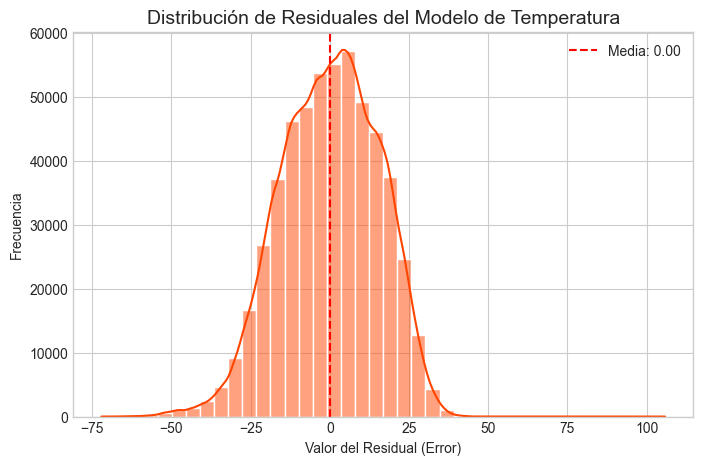

Generando visualización 3D estática de ajuste para 'Temperature(F)'...


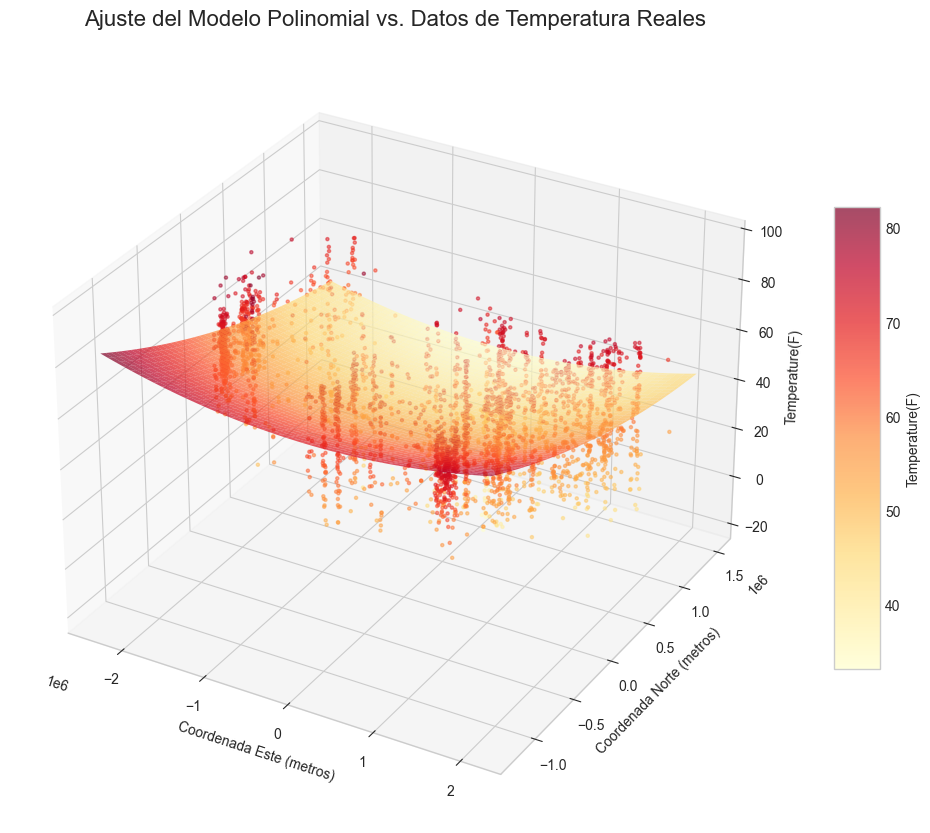


--- ANÁLISIS COMPLETO PARA HUMEDAD a las 7 AM ---
Modelo polinomial de grado 2 entrenado.


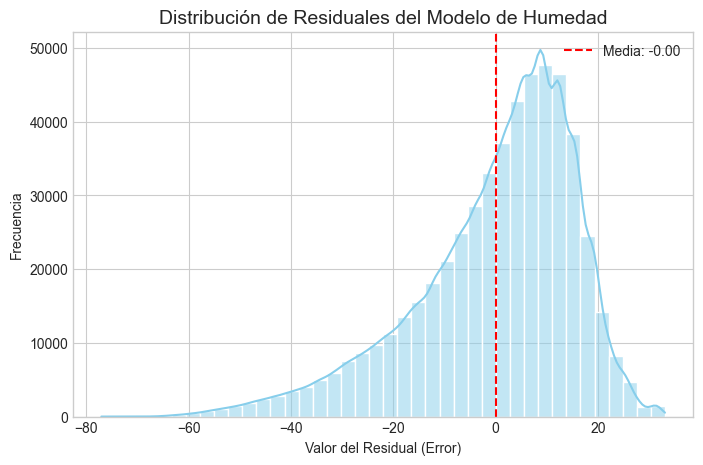

Generando visualización 3D estática de ajuste para 'Humidity(%)'...


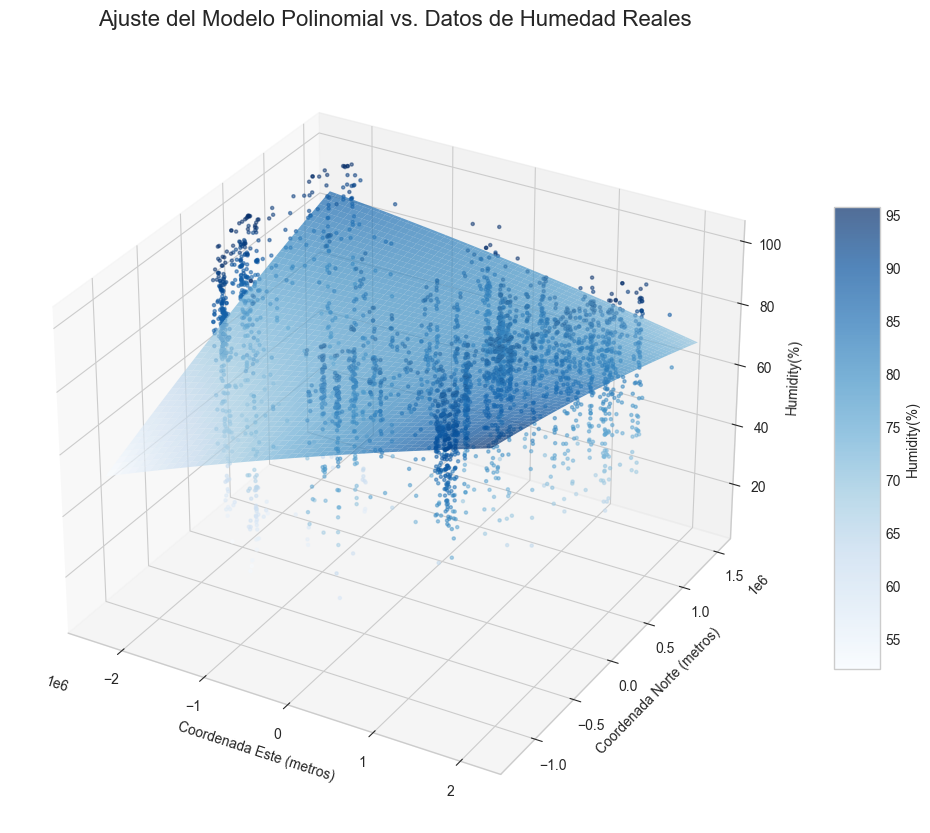


--- GENERANDO EL DATAFRAME FINAL 'df_base' ---
DataFrame 'df_base' creado con las columnas de residuales.
           Este          Norte  Temperature(F)  Humidity(%)  res_temperatura  \
3  9.990134e+05  313998.944555            35.1         96.0       -11.694936   
4  1.002132e+06  300839.636314            36.0         89.0       -10.972501   
5  1.101392e+06  367347.053620            37.9         97.0        -8.719213   
6  9.967674e+05  314907.142449            34.0        100.0       -12.773728   
7  9.995992e+05  316627.508965            34.0        100.0       -12.764950   

   res_humedad  
3    14.889352  
4     7.826795  
5    16.004652  
6    18.896685  
7    18.900048  

--- ANÁLISIS DE CORRELACIÓN ESPACIAL DE RESIDUALES ---
Generando matriz de dispersión (pairplot) de los residuales y la ubicación...


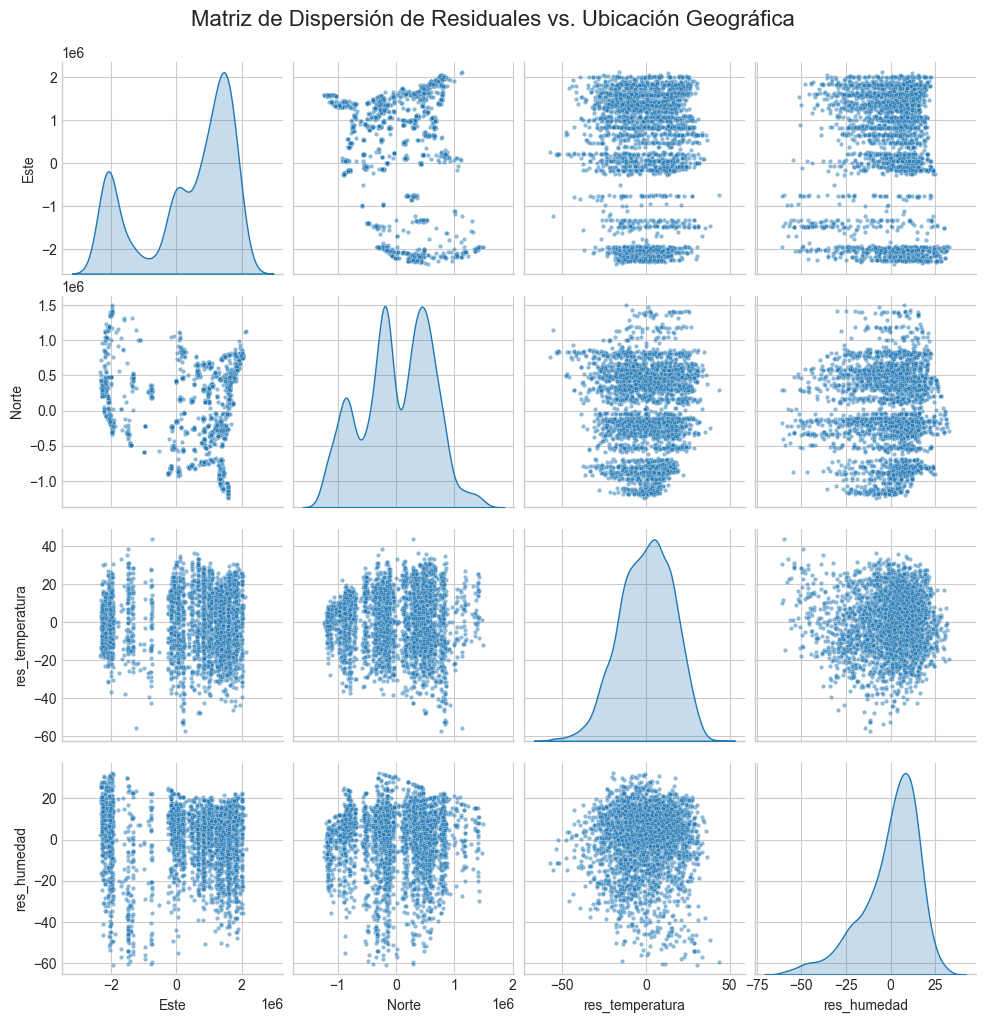

In [6]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# --- PASO 2: DEFINICIÓN DE FUNCIONES MODULARIZADAS ---

def train_polynomial_model(X_data, y_data, degree=2):
    """
    Entrena un modelo de regresión polinomial y devuelve el modelo y el objeto de características.
    """
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X_data)
    
    model = LinearRegression()
    model.fit(X_poly, y_data)
    
    print(f"Modelo polinomial de grado {degree} entrenado.")
    return model, poly_features

def calculate_residuals(model, poly_features, X_full, y_full):
    """
    Usa un modelo entrenado para predecir valores y calcular los residuales.
    Residual = Valor Real - Valor Predicho
    """
    X_poly = poly_features.transform(X_full)
    y_pred = model.predict(X_poly)
    residuals = y_full - y_pred
    return residuals

def plot_residuals_distribution(residuals, title, color):
    """
    Crea un histograma con una curva de densidad para visualizar la distribución de los residuales.
    """
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, color=color, bins=40)
    mean_res = residuals.mean()
    plt.axvline(mean_res, color='red', linestyle='--', label=f'Media: {mean_res:.2f}')
    plt.title(title, fontsize=14)
    plt.xlabel('Valor del Residual (Error)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_model_fit_3d_static(model, poly_features, df_sample, x_col, y_col, z_col, title, cmap):
    """
    Crea una visualización 3D estática que muestra los datos reales y la superficie del modelo.
    """
    print(f"Generando visualización 3D estática de ajuste para '{z_col}'...")
    
    # Preparar la malla para la superficie del modelo
    x_points = df_sample[x_col].values
    y_points = df_sample[y_col].values
    grid_x, grid_y = np.mgrid[x_points.min():x_points.max():100j, y_points.min():y_points.max():100j]
    
    grid_points_flat = np.c_[grid_x.ravel(), grid_y.ravel()]
    grid_poly_features = poly_features.transform(grid_points_flat)
    grid_z = model.predict(grid_poly_features).reshape(grid_x.shape)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x_points, y_points, df_sample[z_col].values, c=df_sample[z_col].values, cmap=cmap, marker='.', alpha=0.5)
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap=cmap, alpha=0.7, edgecolor='none')
    
    ax.set_title(title, fontsize=16, pad=20)
    # --- CORRECCIÓN: Etiquetas de ejes actualizadas ---
    ax.set_xlabel('Coordenada Este (metros)'); ax.set_ylabel('Coordenada Norte (metros)'); ax.set_zlabel(z_col)
    fig.colorbar(surf, shrink=0.6, aspect=10, label=z_col)
    
    plt.show()

# --- PASO 3: EJECUCIÓN PRINCIPAL DEL ANÁLISIS ---
# --- CORRECCIÓN: Usar gdf_7am_proyectado con 'Este' y 'Norte' ---
print("Usando el GeoDataFrame proyectado para el análisis...")
df_model = gdf_7am_proyectado[['Este', 'Norte', 'Temperature(F)', 'Humidity(%)']].dropna()

# Definir variables predictoras (X) y objetivos (y)
X = df_model[['Este', 'Norte']]
y_temp = df_model['Temperature(F)']
y_hum = df_model['Humidity(%)']

# Usar una muestra para la visualización 3D
df_sample = df_model.sample(n=min(3000, len(df_model)), random_state=42)

# --- ANÁLISIS PARA TEMPERATURA ---
print("\n" + "="*50)
print("--- ANÁLISIS COMPLETO PARA TEMPERATURA a las 7 AM ---")
print("="*50)
model_temp, poly_features_temp = train_polynomial_model(X, y_temp)
temp_residuals = calculate_residuals(model_temp, poly_features_temp, X, y_temp)

plot_residuals_distribution(
    residuals=temp_residuals,
    title='Distribución de Residuales del Modelo de Temperatura',
    color='orangered'
)
plot_model_fit_3d_static(
    model=model_temp, poly_features=poly_features_temp, df_sample=df_sample,
    # --- CORRECCIÓN: Usar 'Este' y 'Norte' para graficar ---
    x_col='Este', y_col='Norte', z_col='Temperature(F)',
    title='Ajuste del Modelo Polinomial vs. Datos de Temperatura Reales',
    cmap='YlOrRd'
)

# --- ANÁLISIS PARA HUMEDAD ---
print("\n" + "="*50)
print("--- ANÁLISIS COMPLETO PARA HUMEDAD a las 7 AM ---")
print("="*50)
model_hum, poly_features_hum = train_polynomial_model(X, y_hum)
hum_residuals = calculate_residuals(model_hum, poly_features_hum, X, y_hum)

plot_residuals_distribution(
    residuals=hum_residuals,
    title='Distribución de Residuales del Modelo de Humedad',
    color='skyblue'
)
plot_model_fit_3d_static(
    model=model_hum, poly_features=poly_features_hum, df_sample=df_sample,
    # --- CORRECCIÓN: Usar 'Este' y 'Norte' para graficar ---
    x_col='Este', y_col='Norte', z_col='Humidity(%)',
    title='Ajuste del Modelo Polinomial vs. Datos de Humedad Reales',
    cmap='Blues'
)

# --- PASO 4: CREACIÓN DEL DATAFRAME FINAL CON LOS RESIDUALES ---
print("\n" + "="*50)
print("--- GENERANDO EL DATAFRAME FINAL 'df_base' ---")
print("="*50)

df_base = df_model.copy()
df_base['res_temperatura'] = temp_residuals
df_base['res_humedad'] = hum_residuals

print("DataFrame 'df_base' creado con las columnas de residuales.")
print(df_base.head())


# --- PASO 5: (NUEVO) VISUALIZACIÓN PAIRPLOT DE LOS RESIDUALES ---
print("\n" + "="*50)
print("--- ANÁLISIS DE CORRELACIÓN ESPACIAL DE RESIDUALES ---")
print("="*50)

# Tomar una muestra del DataFrame final para una visualización más ágil
df_sample_res = df_base.sample(n=min(3000, len(df_base)), random_state=42)

print("Generando matriz de dispersión (pairplot) de los residuales y la ubicación...")

pair_plot_res = sns.pairplot(
    df_sample_res,
    vars=['Este', 'Norte', 'res_temperatura', 'res_humedad'],
    kind='scatter',
    diag_kind='kde', # Usamos KDE para una mejor visualización de la distribución
    plot_kws={'alpha': 0.5, 's': 10} # Puntos más pequeños y transparentes
)
pair_plot_res.fig.suptitle('Matriz de Dispersión de Residuales vs. Ubicación Geográfica', y=1.02, fontsize=16)
plt.show()
